<a href="https://colab.research.google.com/github/alim98/MPI/blob/main/Feature_Comp_Fully_interactve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download

In [ ]:
!wget -O downloaded_file.zip "https://drive.usercontent.google.com/download?id=1iHPBdBOPEagvPTHZmrN__LD49emXwReY&export=download&authuser=0&confirm=t&uuid=631d60dd-569c-4bb1-a9e8-d681f0ed3d43&at=APvzH3r4me8x_LwP3n8O7lgPo8oK%3A1733988188000"
!pip -q install umap-learn
!unzip -q downloaded_file.zip
!wget -O ViT_all_features_merged.csv "https://drive.usercontent.google.com/download?id=1rOpINPMO5yqXycFFbJsqURRECwMiHUmP&export=download"


--2025-01-10 13:17:49--  https://drive.usercontent.google.com/download?id=1iHPBdBOPEagvPTHZmrN__LD49emXwReY&export=download&authuser=0&confirm=t&uuid=631d60dd-569c-4bb1-a9e8-d681f0ed3d43&at=APvzH3r4me8x_LwP3n8O7lgPo8oK%3A1733988188000
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.210.132, 2607:f8b0:400c:c0f::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.210.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1264688649 (1.2G) [application/octet-stream]
Saving to: ‘downloaded_file.zip’

downloaded_file.zip 100%[===================>]   1.18G  57.6MB/s    in 18s     

2025-01-10 13:18:07 (67.5 MB/s) - ‘downloaded_file.zip’ saved [1264688649/1264688649]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.4 MB/s eta 0:00:00
--2025-01-10 13:19:33--  https://drive.usercontent.google.com/download?id=1rOpINPMO5y

# InterActive

In [7]:

!pip install dash
import dash

In [18]:
import os
import numpy as np
import pandas as pd
import tifffile as tiff
import imageio.v2 as imageio  # Updated import to address DeprecationWarning
from PIL import Image, ImageDraw, ImageFont  # For overlaying titles
import matplotlib.pyplot as plt
import io
import tempfile
import plotly.express as px
from dash import Dash, dcc, html, Input, Output, State
from sklearn.preprocessing import StandardScaler
import umap

# -----------------------------------------------------------------------------------
# Helper Function: Extract a Single Patch with Padding
# -----------------------------------------------------------------------------------
def extract_patch(slice_data, x_center, y_center, cube_size):
    half_size = cube_size // 2

    x_start = x_center - half_size
    y_start = y_center - half_size
    x_end = x_start + cube_size
    y_end = y_start + cube_size

    # Extract the patch; this might go out of bounds
    patch = slice_data[y_start:y_end, x_start:x_end]

    # Calculate padding if the patch goes out of image boundaries
    pad_left = max(0, -x_start)
    pad_top = max(0, -y_start)
    pad_right = max(0, x_end - slice_data.shape[1])
    pad_bottom = max(0, y_end - slice_data.shape[0])

    if pad_left or pad_top or pad_right or pad_bottom:
        patch = np.pad(
            patch,
            ((pad_top, pad_bottom), (pad_left, pad_right)),
            mode='constant',
            constant_values=0
        )

    # Ensure the patch is exactly (cube_size, cube_size)
    patch = patch[:cube_size, :cube_size]

    # In case the patch is still smaller due to extreme boundary conditions
    if patch.shape[0] < cube_size or patch.shape[1] < cube_size:
        patch = np.pad(
            patch,
            (
                (0, cube_size - patch.shape[0]),
                (0, cube_size - patch.shape[1])
            ),
            mode='constant',
            constant_values=0
        )
        patch = patch[:cube_size, :cube_size]

    # Final assertion to ensure patch size
    assert patch.shape == (cube_size, cube_size), f"Patch shape {patch.shape} is not ({cube_size}, {cube_size})"

    return patch

# -----------------------------------------------------------------------------------
# Function: Extract Cube from Slices
# -----------------------------------------------------------------------------------
def extract_cube(folder_path, central_coords, cube_size=80):
    x_center, y_center, z_center = central_coords
    half_size = cube_size // 2
    cube = []

    # Load the central slice first to get image dimensions
    central_slice_path = os.path.join(folder_path, f"slice_{z_center}.tif")
    if not os.path.exists(central_slice_path):
        raise FileNotFoundError(f"Central slice {central_slice_path} does not exist.")

    central_slice = tiff.imread(central_slice_path)
    img_height, img_width = central_slice.shape
    print(f"Central slice dimensions: {central_slice.shape}")

    for z in range(z_center - half_size, z_center + half_size):
        slice_path = os.path.join(folder_path, f"slice_{z}.tif")
        if os.path.exists(slice_path):
            slice_data = tiff.imread(slice_path)
            # Verify slice dimensions
            if slice_data.shape != (img_height, img_width):
                raise ValueError(f"Slice {z} has inconsistent dimensions: {slice_data.shape}")
            # Extract the patch with proper padding
            try:
                patch = extract_patch(slice_data, x_center, y_center, cube_size)
                cube.append(patch)
                print(f"Extracted patch from slice {z}")
            except AssertionError as ae:
                print(f"Assertion Error for slice {z}: {ae}")
                # Append a zero-filled patch to maintain consistency
                cube.append(np.zeros((cube_size, cube_size)))
        else:
            # If the slice doesn't exist, append a zero-filled patch
            print(f"Slice {z} does not exist. Appending zero-filled patch.")
            cube.append(np.zeros((cube_size, cube_size)))

    # Verify that all patches have the same shape
    patch_shapes = [patch.shape for patch in cube]
    if not all(shape == (cube_size, cube_size) for shape in patch_shapes):
        raise ValueError("Not all patches have the shape (cube_size, cube_size).")
    else:
        print("All patches have consistent shapes.")

    return np.stack(cube)

# -----------------------------------------------------------------------------------
# Function: Create GIF with Titles Using Pillow for Consistent Frame Sizes
# -----------------------------------------------------------------------------------
def create_gif_with_titles(cube, output_path, var1, bbox_name, z_center):
    frames = []
    # Define fixed figure size and DPI
    fig_size = (4, 4)  # inches
    fig_dpi = 100       # dots per inch

    # Define font for text overlay using Pillow
    try:
        font = ImageFont.truetype("arial.ttf", 15)  # Adjust the font path and size as needed
    except IOError:
        font = ImageFont.load_default()

    for i, slice_data in enumerate(cube):
        fig, ax = plt.subplots(figsize=fig_size, dpi=fig_dpi)
        ax.imshow(slice_data, cmap='gray')
        ax.axis('off')

        # Save figure to a bytes buffer without title
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        buf.seek(0)
        frame = Image.open(buf).convert("RGBA")
        plt.close(fig)

        # Prepare the title
        slice_number = z_center - (len(cube) // 2) + i
        title = f"Var1: {var1}, BBox: {bbox_name}, Slice: {slice_number}"

        # Overlay the title on the image using Pillow
        draw = ImageDraw.Draw(frame)
        text_position = (10, 10)  # Top-left corner; adjust as needed
        draw.text(text_position, title, font=font, fill=(255, 255, 255, 255))  # White text

        # Convert back to numpy array
        frame_np = np.array(frame)
        frames.append(frame_np)

    # Verify all frames have the same shape
    frame_shapes = [frame.shape for frame in frames]
    first_shape = frame_shapes[0]
    inconsistent = False
    for idx, shape in enumerate(frame_shapes):
        if shape != first_shape:
            print(f"Frame {idx} has shape {shape}, expected {first_shape}.")
            inconsistent = True
    if inconsistent:
        raise ValueError("Not all frames have the same shape.")
    else:
        print("All frames have consistent shapes.")

    # Save the GIF using the updated imageio import
    imageio.mimsave(output_path, frames, fps=5)
    print(f"GIF saved to {output_path}")

# -----------------------------------------------------------------------------------
# Function: Process Features and Apply UMAP
# -----------------------------------------------------------------------------------
def process_features(df):
    feature_cols = [c for c in df.columns if c.startswith('feat_')]
    features = df[feature_cols].values
    features_scaled = StandardScaler().fit_transform(features)
    return features_scaled

def reduce_to_umap(features_scaled):
    umap_direct = umap.UMAP(n_components=2, random_state=42)
    return umap_direct.fit_transform(features_scaled)

# -----------------------------------------------------------------------------------
# Initialize Dash App
# -----------------------------------------------------------------------------------
app = Dash(__name__)

# -----------------------------------------------------------------------------------
# Load Data
# -----------------------------------------------------------------------------------
file_path = 'ViT_all_features_merged.csv'  # Ensure this is the correct path
if not os.path.exists(file_path):
    raise FileNotFoundError(f"CSV file {file_path} does not exist.")

df = pd.read_csv(file_path)

# Add 'id' column for unique identification
df.reset_index(inplace=True)
df.rename(columns={'index': 'id'}, inplace=True)

# Process Features and Apply UMAP
features_scaled = process_features(df)
umap_direct_result = reduce_to_umap(features_scaled)

df['umap_1'] = umap_direct_result[:, 0]
df['umap_2'] = umap_direct_result[:, 1]

# -----------------------------------------------------------------------------------
# Dash Layout
# -----------------------------------------------------------------------------------
app.layout = html.Div([
    dcc.Graph(
        id='umap-plot',
        figure=px.scatter(
            df, x='umap_1', y='umap_2', color='bbox_name',
            hover_data=['id', 'Var1', 'central_coord_1', 'central_coord_2', 'central_coord_3', 'bbox_name'],
            title="ViT - Direct UMAP"
        )
    ),
    html.Button("Done", id='done-button', n_clicks=0, style={'marginTop': 20}),
    dcc.Download(id='download-gif'),
    dcc.Download(id='download-log'),
    html.Div(id='gif-output', style={'marginTop': 20}),
    dcc.Store(id='log-store', data=[])  # Store to keep track of clicked data points
])

# -----------------------------------------------------------------------------------
# Callback to Generate GIF and Log Clicked Data
# -----------------------------------------------------------------------------------
@app.callback(
    [
        Output('gif-output', 'children'),
        Output('download-gif', 'data'),
        Output('log-store', 'data')
    ],
    [
        Input('umap-plot', 'clickData')
    ],
    [
        State('log-store', 'data')
    ]
)
def generate_gif(click_data, existing_log):
    if click_data:
        try:
            # Get clicked sample details
            point = click_data['points'][0]
            customdata = point['customdata']
            id_ = customdata[0]
            var1 = customdata[1]
            central_x = int(customdata[2])
            central_y = int(customdata[3])
            central_z = int(customdata[4])
            bbox_name = customdata[5]

            central_coords = (central_x, central_y, central_z)

            # Define folder path
            folder_path = os.path.join('raw', bbox_name)  # Adjust this path if necessary
            if not os.path.exists(folder_path):
                return f"Folder {folder_path} does not exist.", None, existing_log

            # Extract cube and generate GIF
            cube = extract_cube(folder_path, central_coords)
            gif_filename = f"{var1}.gif"
            create_gif_with_titles(cube, gif_filename, var1, bbox_name, central_z)

            # Update the log
            log_entry = {
                'id': id_,
                'synapse_name': var1,
                'central_coord_1': central_x,
                'central_coord_2': central_y,
                'central_coord_3': central_z,
                'bbox_name': bbox_name,
                'center_slice': central_z
            }
            updated_log = existing_log.copy()
            updated_log.append(log_entry)

            # Provide GIF for download
            return f"GIF generated: {gif_filename}", dcc.send_file(gif_filename), updated_log
        except Exception as e:
            return f"Error generating GIF: {str(e)}", None, existing_log

    return "Click on a point to generate a GIF.", None, existing_log

# -----------------------------------------------------------------------------------
# Callback to Export Log as CSV
# -----------------------------------------------------------------------------------
@app.callback(
    Output('download-log', 'data'),
    [
        Input('done-button', 'n_clicks')
    ],
    [
        State('log-store', 'data')
    ],
    prevent_initial_call=True
)
def export_log(n_clicks, log_data):
    if n_clicks > 0 and log_data:
        # Convert log data to DataFrame
        log_df = pd.DataFrame(log_data)

        # Define the CSV file name
        csv_filename = "clicked_data_log.csv"

        # Return the CSV file for download
        return dcc.send_data_frame(log_df.to_csv, csv_filename, index=False)

    return None

# -----------------------------------------------------------------------------------
# Run the Dash App
# -----------------------------------------------------------------------------------
if __name__ == "__main__":
    app.run_server(debug=True)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



<IPython.core.display.Javascript object>

Central slice shape: (575, 575)
Extracted patch shape: (80, 80)


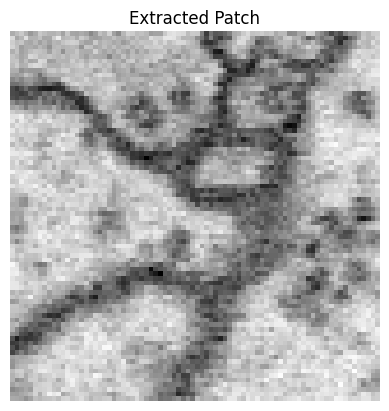

In [15]:
import os
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

# Define the extract_patch function (as provided)
def extract_patch(slice_data, x_center, y_center, cube_size):
    half_size = cube_size // 2

    x_start = x_center - half_size
    y_start = y_center - half_size
    x_end = x_start + cube_size
    y_end = y_start + cube_size

    # Extract the patch; this might go out of bounds
    patch = slice_data[y_start:y_end, x_start:x_end]

    # Calculate padding if the patch goes out of image boundaries
    pad_left = max(0, -x_start)
    pad_top = max(0, -y_start)
    pad_right = max(0, x_end - slice_data.shape[1])
    pad_bottom = max(0, y_end - slice_data.shape[0])

    if pad_left or pad_top or pad_right or pad_bottom:
        patch = np.pad(
            patch,
            ((pad_top, pad_bottom), (pad_left, pad_right)),
            mode='constant',
            constant_values=0
        )

    # Ensure the patch is exactly (cube_size, cube_size)
    patch = patch[:cube_size, :cube_size]

    # In case the patch is still smaller due to extreme boundary conditions
    if patch.shape[0] < cube_size or patch.shape[1] < cube_size:
        patch = np.pad(
            patch,
            (
                (0, cube_size - patch.shape[0]),
                (0, cube_size - patch.shape[1])
            ),
            mode='constant',
            constant_values=0
        )
        patch = patch[:cube_size, :cube_size]

    # Final assertion to ensure patch size
    assert patch.shape == (cube_size, cube_size), f"Patch shape {patch.shape} is not ({cube_size}, {cube_size})"

    return patch

# Function to visualize patches
def visualize_patch(patch, title="Patch"):
    plt.imshow(patch, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Define the test parameters based on your data row
var1 = "explorative_2024-10-16_Valentin_Pinkau_116"
x_center = 474
y_center = 109
z_center = 332
cube_size = 80
bbox_name = "bbox1"  # Adjust if different

# Define the path to the central slice
root_dir = "/content"  # Replace with your actual root directory if different
central_slice_path = os.path.join(root_dir, "raw", bbox_name, f"slice_{z_center}.tif")

# Check if the central slice exists
if not os.path.exists(central_slice_path):
    raise FileNotFoundError(f"Central slice {central_slice_path} does not exist.")

# Load the central slice
central_slice = tiff.imread(central_slice_path)
print(f"Central slice shape: {central_slice.shape}")  # e.g., (512, 512)

# Extract the patch
try:
    patch = extract_patch(central_slice, x_center, y_center, cube_size)
    print(f"Extracted patch shape: {patch.shape}")  # Should be (80, 80)
    visualize_patch(patch, title="Extracted Patch")
except AssertionError as ae:
    print(f"Assertion Error: {ae}")
except Exception as e:
    print(f"Error during patch extraction: {e}")


Central slice dimensions: (575, 575)
Extracted patch from slice 292
Extracted patch from slice 293
Extracted patch from slice 294
Extracted patch from slice 295
Extracted patch from slice 296
Extracted patch from slice 297
Extracted patch from slice 298
Extracted patch from slice 299
Extracted patch from slice 300
Extracted patch from slice 301
Extracted patch from slice 302
Extracted patch from slice 303
Extracted patch from slice 304
Extracted patch from slice 305
Extracted patch from slice 306
Extracted patch from slice 307
Extracted patch from slice 308
Extracted patch from slice 309
Extracted patch from slice 310
Extracted patch from slice 311
Extracted patch from slice 312
Extracted patch from slice 313
Extracted patch from slice 314
Extracted patch from slice 315
Extracted patch from slice 316
Extracted patch from slice 317
Extracted patch from slice 318
Extracted patch from slice 319
Extracted patch from slice 320
Extracted patch from slice 321
Extracted patch from slice 322
Ex

<ipython-input-17-b5e374ff1b3e>:123: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



Frame 0 shape: (370, 529, 4)
Frame 1 shape: (370, 529, 4)
Frame 2 shape: (370, 529, 4)
Frame 3 shape: (370, 529, 4)
Frame 4 shape: (370, 529, 4)
Frame 5 shape: (370, 529, 4)
Frame 6 shape: (370, 529, 4)
Frame 7 shape: (370, 529, 4)
Frame 8 shape: (370, 528, 4)
Frame 9 shape: (370, 529, 4)
Frame 10 shape: (370, 528, 4)
Frame 11 shape: (370, 528, 4)
Frame 12 shape: (370, 528, 4)
Frame 13 shape: (370, 528, 4)
Frame 14 shape: (370, 529, 4)
Frame 15 shape: (370, 528, 4)
Frame 16 shape: (370, 529, 4)
Frame 17 shape: (370, 529, 4)
Frame 18 shape: (370, 529, 4)
Frame 19 shape: (370, 529, 4)
Frame 20 shape: (370, 529, 4)
Frame 21 shape: (370, 529, 4)
Frame 22 shape: (370, 529, 4)
Frame 23 shape: (370, 529, 4)
Frame 24 shape: (370, 529, 4)
Frame 25 shape: (370, 529, 4)
Frame 26 shape: (370, 529, 4)
Frame 27 shape: (370, 529, 4)
Frame 28 shape: (370, 528, 4)
Frame 29 shape: (370, 529, 4)
Frame 30 shape: (370, 528, 4)
Frame 31 shape: (370, 528, 4)
Frame 32 shape: (370, 528, 4)
Frame 33 shape: (370

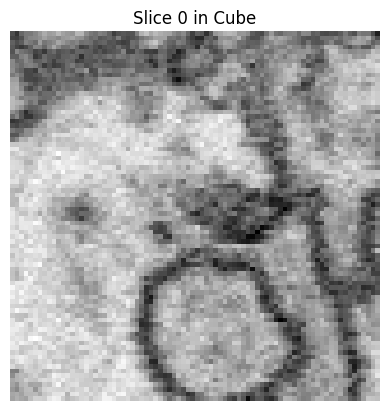

Visualizing slice 40 in cube.


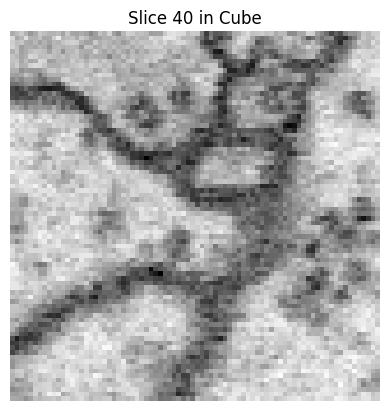

Visualizing slice 79 in cube.


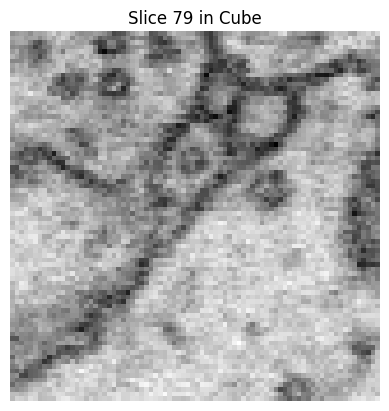

In [17]:
import os
import numpy as np
import pandas as pd
import tifffile as tiff
import matplotlib.pyplot as plt
import imageio
import io

# Define the extract_patch function (as above)
def extract_patch(slice_data, x_center, y_center, cube_size):
    half_size = cube_size // 2

    x_start = x_center - half_size
    y_start = y_center - half_size
    x_end = x_start + cube_size
    y_end = y_start + cube_size

    # Extract the patch; this might go out of bounds
    patch = slice_data[y_start:y_end, x_start:x_end]

    # Calculate padding if the patch goes out of image boundaries
    pad_left = max(0, -x_start)
    pad_top = max(0, -y_start)
    pad_right = max(0, x_end - slice_data.shape[1])
    pad_bottom = max(0, y_end - slice_data.shape[0])

    if pad_left or pad_top or pad_right or pad_bottom:
        patch = np.pad(
            patch,
            ((pad_top, pad_bottom), (pad_left, pad_right)),
            mode='constant',
            constant_values=0
        )

    # Ensure the patch is exactly (cube_size, cube_size)
    patch = patch[:cube_size, :cube_size]

    # In case the patch is still smaller due to extreme boundary conditions
    if patch.shape[0] < cube_size or patch.shape[1] < cube_size:
        patch = np.pad(
            patch,
            (
                (0, cube_size - patch.shape[0]),
                (0, cube_size - patch.shape[1])
            ),
            mode='constant',
            constant_values=0
        )
        patch = patch[:cube_size, :cube_size]

    # Final assertion to ensure patch size
    assert patch.shape == (cube_size, cube_size), f"Patch shape {patch.shape} is not ({cube_size}, {cube_size})"

    return patch

# Define the extract_cube function (as above)
def extract_cube(folder_path, central_coords, cube_size=80):
    x_center, y_center, z_center = central_coords
    half_size = cube_size // 2
    cube = []

    # Load the central slice first to get image dimensions
    central_slice_path = os.path.join(folder_path, f"slice_{z_center}.tif")
    if not os.path.exists(central_slice_path):
        raise FileNotFoundError(f"Central slice {central_slice_path} does not exist.")

    central_slice = tiff.imread(central_slice_path)
    img_height, img_width = central_slice.shape
    print(f"Central slice dimensions: {central_slice.shape}")

    for z in range(z_center - half_size, z_center + half_size):
        slice_path = os.path.join(folder_path, f"slice_{z}.tif")
        if os.path.exists(slice_path):
            slice_data = tiff.imread(slice_path)
            # Verify slice dimensions
            if slice_data.shape != (img_height, img_width):
                raise ValueError(f"Slice {z} has inconsistent dimensions: {slice_data.shape}")
            # Extract the patch with proper padding
            try:
                patch = extract_patch(slice_data, x_center, y_center, cube_size)
                cube.append(patch)
                print(f"Extracted patch from slice {z}")
            except AssertionError as ae:
                print(f"Assertion Error for slice {z}: {ae}")
                # Append a zero-filled patch to maintain consistency
                cube.append(np.zeros((cube_size, cube_size)))
        else:
            # If the slice doesn't exist, append a zero-filled patch
            print(f"Slice {z} does not exist. Appending zero-filled patch.")
            cube.append(np.zeros((cube_size, cube_size)))

    # Verify that all patches have the same shape
    patch_shapes = [patch.shape for patch in cube]
    if not all(shape == (cube_size, cube_size) for shape in patch_shapes):
        raise ValueError("Not all patches have the shape (cube_size, cube_size).")
    else:
        print("All patches have consistent shapes.")

    return np.stack(cube)

# Define the create_gif_with_titles function (as above)
def create_gif_with_titles(cube, output_path, var1, bbox_name, z_center):
    frames = []
    # Define fixed figure size and DPI
    fig_size = (4, 4)  # inches
    fig_dpi = 100       # dots per inch
    image_width = fig_size[0] * fig_dpi
    image_height = fig_size[1] * fig_dpi

    for i, slice_data in enumerate(cube):
        fig, ax = plt.subplots(figsize=fig_size, dpi=fig_dpi)
        ax.imshow(slice_data, cmap='gray')
        ax.axis('off')
        slice_number = z_center - (len(cube) // 2) + i
        title = f"Var1: {var1}, BBox: {bbox_name}, Slice: {slice_number}"
        ax.set_title(title, fontsize=10)
        plt.tight_layout()

        # Save figure to a bytes buffer instead of a temporary file
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        buf.seek(0)
        frame = imageio.imread(buf)

        # Debug: Print frame shape
        print(f"Frame {i} shape: {frame.shape}")

        frames.append(frame)
        plt.close(fig)

    # Verify all frames have the same shape
    frame_shapes = [frame.shape for frame in frames]
    first_shape = frame_shapes[0]
    for idx, shape in enumerate(frame_shapes):
        if shape != first_shape:
            print(f"Frame {idx} has shape {shape}, expected {first_shape}.")
    if not all(shape == first_shape for shape in frame_shapes):
        raise ValueError("Not all frames have the same shape.")
    else:
        print("All frames have consistent shapes.")

    # Save the GIF
    imageio.mimsave(output_path, frames, fps=5)
    print(f"GIF saved to {output_path}")

# Define the function to run all tests
def run_comprehensive_test(data_row, root_dir="/content"):
    """
    data_row: List or tuple containing the data elements in order.
    root_dir: Root directory where 'raw' folder is located.
    """
    # Unpack data_row
    # Example data_row:
    # ['explorative_2024-10-16_Valentin_Pinkau_116', 474, 109, 332, 466, 109, 325, 483, 109, 344]
    if len(data_row) < 10:
        raise ValueError("Data row does not contain enough elements.")

    var1 = data_row[0]
    central_coord_1 = int(data_row[1])
    central_coord_2 = int(data_row[2])
    central_coord_3 = int(data_row[3])
    # side_1 and side_2 coordinates are data_row[4] to data_row[9], not used in this test

    # Assume bbox_name is part of the data or infer it
    # For this test, we'll set it manually. Adjust as needed.
    bbox_name = "bbox1"  # Replace with actual bbox_name if different

    # Define central coordinates
    central_coords = (central_coord_1, central_coord_2, central_coord_3)
    cube_size = 80

    # Define the path to the raw data folder
    folder_path = os.path.join(root_dir, "raw", bbox_name)

    # Extract the cube
    try:
        cube = extract_cube(folder_path, central_coords, cube_size=cube_size)
        print(f"Extracted cube shape: {cube.shape}")  # Expected: (80, 80, 80)

        # Define GIF parameters
        output_gif = f"{var1}_bbox{bbox_name}_z{central_coord_3}.gif"

        # Create the GIF
        create_gif_with_titles(cube, output_gif, var1, bbox_name, central_coord_3)

        # Verify the GIF file exists
        if os.path.exists(output_gif):
            print("GIF successfully created.")
        else:
            print("GIF creation failed.")

    except FileNotFoundError as fnf_error:
        print(fnf_error)
    except ValueError as val_error:
        print(val_error)
    except AssertionError as ae:
        print(ae)
    except Exception as e:
        print(f"An unexpected error occurred during testing: {e}")

    # Optional: Visualize a few patches and frames
    try:
        # Visualize the first, middle, and last patches
        slice_indices = [0, cube_size//2, cube_size-1]
        for idx in slice_indices:
            plt.imshow(cube[idx], cmap='gray')
            print(f"Visualizing slice {idx} in cube.")
            plt.title(f"Slice {idx} in Cube")
            plt.axis('off')
            plt.show()
    except Exception as e:
        print(f"Error during visualization: {e}")

# Example usage with your data row
data_row = [
    "explorative_2024-10-16_Valentin_Pinkau_116",
    474,  # central_coord_1
    109,  # central_coord_2
    332,  # central_coord_3
    466,  # side_1_coord_1
    109,  # side_1_coord_2
    325,  # side_1_coord_3
    483,  # side_2_coord_1
    109,  # side_2_coord_2
    344   # side_2_coord_3
]

# Run the comprehensive test
run_comprehensive_test(data_row, root_dir="/content")  # Adjust root_dir if different


# Just Vit direct Umap

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import umap
import plotly.graph_objects as go

def process_features(df):
    feature_cols = [c for c in df.columns if c.startswith('feat_')]
    features = df[feature_cols].values

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    return features_scaled

def reduce_to_umap(features_scaled):
    umap_direct = umap.UMAP(n_components=2, random_state=42)
    umap_direct_result = umap_direct.fit_transform(features_scaled)

    return umap_direct_result

def create_vit_umap_plot():
    # Define consistent colors for each bbox
    color_mapping = {
        'bbox1': '#FF0000',  # Red
        'bbox2': '#00FFFF',  # Cyan
        'bbox3': '#FFA500',  # Orange
        'bbox4': '#800080',  # Purple
        'bbox5': '#808080',  # Gray
        'bbox6': '#0000FF',  # Blue
        'bbox7': '#000000'   # Black
    }

    file_path = 'ViT_all_features_merged.csv'
    df = pd.read_csv(file_path)
    features_scaled = process_features(df)
    umap_direct_result = reduce_to_umap(features_scaled)

    fig = go.Figure()

    for bbox in sorted(df['bbox_name'].unique()):  # Sort to ensure consistent order
        mask = df['bbox_name'] == bbox

        fig.add_trace(
            go.Scatter(
                x=umap_direct_result[mask, 0],
                y=umap_direct_result[mask, 1],
                mode='markers',
                name=bbox,
                marker=dict(
                    size=5,
                    color=color_mapping.get(bbox, '#000000'),  # Default to black if bbox not in mapping
                    opacity=0.7
                ),
                text=df[mask]['Var1'],
                hovertemplate=(
                    'Label: %{text}<br>'
                    'x: %{x:.2f}<br>'
                    'y: %{y:.2f}<br>'
                    'bbox: ' + bbox + '<br>'
                    '<extra></extra>'
                )
            )
        )

    fig.update_layout(
        height=600,
        width=800,
        title_text="ViT - Direct UMAP",
        showlegend=True,
        xaxis_title="UMAP 1",
        yaxis_title="UMAP 2"
    )

    return fig

def main():
    fig = create_vit_umap_plot()
    fig.show()

    fig.write_html("vit_direct_umap.html")
    print("Visualization has been saved as 'vit_direct_umap.html'")

if __name__ == "__main__":
    main()


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Visualization has been saved as 'vit_direct_umap.html'
